## Avaliação 1
### Sistema de Recomendação Spotify

#### Matérial utilizado como referência:
##### Clusterização https://www.kaggle.com/code/vatsalmavani/music-recommendation-system-using-spotify-dataset
##### Sistema de recomendação https://www.kaggle.com/code/prathamsharma123/spotify-eda-recommendation-system
 

In [93]:
#bibliotecas utilizadas

#tratamento 
import pandas as pd
import numpy as np

#clusterização e visualização com PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.express as px 

#recomendação
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [94]:
#Lendo o arquivo spotfy.csv
df = pd.read_csv("C:/Users/Yasmin/Downloads/archive 2/spotify-2023.csv", encoding= 'ISO-8859-1')
df.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

## Tratando colunas textuais

In [96]:
#identificando o registro tipo object da coluna streams

df[df['streams'] == 'BPM110KeyAModeMajorDanceability53Valence75Energy69Acousticness7Instrumentalness0Liveness17Speechiness3']

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
574,Love Grows (Where My Rosemary Goes),Edison Lighthouse,1,1970,1,1,2877,0,BPM110KeyAModeMajorDanceability53Valence75Ener...,16,...,110,A,Major,53,75,69,7,0,17,3


In [97]:
#deletando registro

df.drop(index= 574, axis = 1, inplace = True)

In [98]:
#após deletar registro é possivel converter a coluna para tipo inteiro

df['streams'] = df['streams'].astype(np.int64)

In [99]:
#deletando outras colunas tipo object menos importantes
df.drop(columns = ['in_shazam_charts', 'in_deezer_playlists' ], axis = 1, inplace = True)

## Clusterização (K-Means)

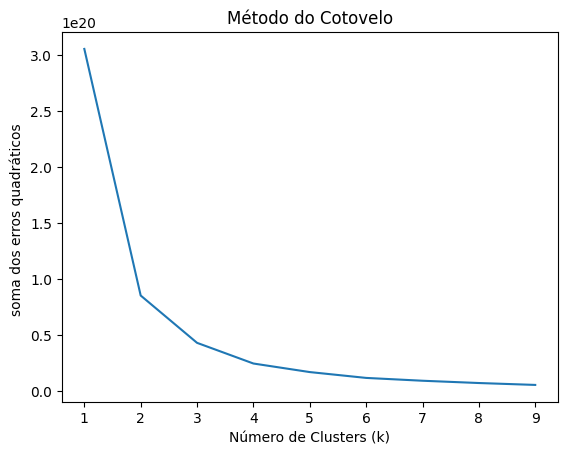

In [100]:
#método cotovelo para definir quantidade de clusters

X = df.select_dtypes(np.number)

# Defina o intervalo de valores k
k_range = range(1, 10)

# Execute o algoritmo de clustering para cada valor k e armazene a soma dos erros quadráticos em uma lista
sse = []
for k in k_range:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

# Trace a curva de cotovelo
plt.plot(k_range, sse)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('soma dos erros quadráticos ')
plt.title('Método do Cotovelo')
plt.show()

In [101]:
#fazendo a clusterização utilizando pipeline

song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=2, 
                                   verbose=False))
                                 ], verbose=False)

X = df.select_dtypes(np.number)
number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
df['cluster_label'] = song_cluster_labels

In [102]:
#visualização dos clusters com PCA

pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = df['track_name']
projection['cluster'] = df['cluster_label']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
fig.show()

## Construindo sistema de recomendação


In [103]:
#organizando as musicas por quantidade streams
song_library = df.sort_values(by=['streams'], ascending=False)

# resetendo index
song_library.reset_index(inplace=True, drop=True)

song_library.head()


,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,cluster_label
0,Blinding Lights,The Weeknd,1,2019,11,29,43899,69,3703895074,672,...,C#,Major,50,38,80,0,0,9,7,1
1,Shape of You,Ed Sheeran,1,2017,1,6,32181,10,3562543890,33,...,C#,Minor,83,93,65,58,0,9,8,1
2,Someone You Loved,Lewis Capaldi,1,2018,11,8,17836,53,2887241814,440,...,C#,Major,50,45,41,75,0,11,3,1
3,Dance Monkey,Tones and I,1,2019,5,10,24529,0,2864791672,533,...,F#,Minor,82,54,59,69,0,18,10,1
4,Sunflower - Spider-Man: Into the Spider-Verse,"Post Malone, Swae Lee",2,2018,10,9,24094,78,2808096550,372,...,D,Major,76,91,50,54,0,7,5,1


In [104]:
# Utilizando CountVectorizer para tranformar texto em vetor
song_vectorizer = CountVectorizer()

# aplicando na coluna mode
song_vectorizer.fit(song_library['mode'])

CountVectorizer()

In [106]:
#para construir o sistema de recomendação será necessário fazer calculos com as colunas do tipo númerico

colunas_num  = df.select_dtypes(include='int64').columns.tolist()

['artist_count',
 'released_year',
 'released_month',
 'released_day',
 'in_spotify_playlists',
 'in_spotify_charts',
 'streams',
 'in_apple_playlists',
 'in_apple_charts',
 'in_deezer_charts',
 'bpm',
 'danceability_%',
 'valence_%',
 'energy_%',
 'acousticness_%',
 'instrumentalness_%',
 'liveness_%',
 'speechiness_%']

In [ ]:
# Função para recomendar músicas similares
def song_recommender(song_name):
    try:
        # colunas numéricas
        num_cols = colunas_num

        # Craindo um vetor a partir da coluna mode para a musica passada
        text_vec1 = song_vectorizer.transform(song_library[song_library['track_name']==str(song_name)]['mode']).toarray()

        # Criando um vetor numerico da musica passada
        num_vec1 = song_library[song_library['track_name']==str(song_name)][num_cols].to_numpy()

        # Lista em branco para guardar a similaridade
        sim_scores=  []

        # Determinar similaridade de coseno para cada música do data frame com a musica passada na função

        for index, row in song_library.iterrows():
            name = row['track_name']

            # Vetor utilizando coluna mode para as demais musicas do data frame
            text_vec2 = song_vectorizer.transform(song_library[song_library['track_name']==name]['mode']).toarray()

            # Vetor com as colunas numericas para as demais musicas
            num_vec2 = song_library[song_library['track_name']==name][num_cols].to_numpy()

            # calculando a similaridade de cossenos para os vetores textuais
            text_sim = cosine_similarity(text_vec1, text_vec2)[0][0]

            # calculando a similaridade de cossenos para os vetores numericos
            num_sim = cosine_similarity(num_vec1, num_vec2)[0][0]

            # Tirando a média das similaridades e adicionando na lista de sim_scores
            sim = (text_sim + num_sim)/2
            sim_scores.append(sim)
        
        # Adicionar coluna contendo a similaridades para o dataframe song_library
        song_library['similarity'] = sim_scores

        # Organizando o dataframe com base na nova coluna similarity
        song_library.sort_values(by=['similarity', 'streams', 'released_year'], ascending=[False, False, False], inplace=True)

        # Criando dataframe das 5 músicas recomendadas com base na musica passada
        recommended_songs = song_library[['track_name', 'artist(s)_name', 'released_year']][2:7]
        return recommended_songs
    except:
        # Mensagem de erro caso a música não exista no dataframe
        print('{} not found in songs library.'.format(song_name))

In [110]:
#Recomendando músicas parecidas com Cruel Summer da Taylor Swift
song_recommender('Cruel Summer')

,track_name,artist(s)_name,released_year
199,Style,Taylor Swift,2014
188,Bad Habit,Steve Lacy,2022
173,Lover,Taylor Swift,2012
208,Late Night Talking,Harry Styles,2022
216,we fell in love in october,girl in red,2018
